In [1]:
import copy
import logging
import inspect
import operator
import numpy as np
import functools as ft
from dataclasses import dataclass, field
from typing import Callable, Dict, Iterable, List, Optional, Any

In [2]:
from util.parameters import normalize_parameter_specs, _UNSET
from util.reporting import (
    wrap_expr,
    build_expr,
    pretty_expr,
    lmfit_report,
    r_squared_safe, 
    pretty_print_params,
    get_default_logger
)
from util.plotting import (
    # pretty_plot,
    # get_pretty_axarray,
    # plot_from_fitdata,
    FitPlotter
)
from util.utils import(
    parse_xrange
)

In [3]:
# --- The package lmfit is a MUST
try:
    import lmfit
except Exception as exc:  # pragma: no cover - runtime dependency
    raise ImportError("lmfit is required. Install with `pip install lmfit`") from exc

In [ ]:
_VALID_CONNECTORS = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv,
}


# _ALLOWED_HINT_KEYS = {
#     "value", "vary", 
#     "min", "max", 
#     "expr", "brute_step"
#     }

_LMFIT_INIT_PARAMETER_DEFAULTS = {
            'value': -np.inf, 'vary': True,
            'min': -np.inf, 'max': +np.inf,
            'expr': None, 'brute_step': None
        }

_ALLOWED_NUMERIC = (int, float)



@dataclass
class ModelSpec:
    func: Callable
    init_params: Dict[str, dict]
    func_kws: Dict[str, object] = field(default_factory=dict)


@dataclass
class FitData:
    x_data: np.ndarray
    y_data: np.ndarray
    x_model: np.ndarray
    y_init: np.ndarray
    y_fit: np.ndarray | None
    resid_init: np.ndarray
    resid_fit: np.ndarray | None
    components: Optional[
        Dict[int, Dict[str, Dict[str, np.ndarray]]]
    ] = None

    # ---- derived properties ----

    @property
    def has_fit(self) -> bool:
        return self.y_fit is not None

    @property
    def has_components(self) -> bool:
        return self.components is not None

    @property
    def is_multicomponent(self) -> bool:
        return self.has_components and any(self.components.values())

    @property
    def n_datasets(self) -> int:
        return len(self.components) if self.has_components else 1
    
    @property
    def is_multidataset(self) -> bool:
        return self.n_datasets > 1

    @property
    def component_names(self) -> list[str]:
        if not self.has_components:
            return []
        names = set()
        for comps in self.components.values():
            names.update(comps.keys())
        return sorted(names)



class LmfitGlobal:
    """_summary_
    """



    @staticmethod
    def evaluate_function(
        func: Callable, 
        x: np.ndarray, 
        params: lmfit.Parameters, 
        prefix: str, 
        i: int, 
        func_kws=None
        ) -> np.ndarray:
        """Evaluate a single function with parameters from lmfit and `func` keyward arguments (if any).

        Args:
            func (callable): The function to evaluate
            x (array, list of floats): Array-like of x data
            params (lmfit.Parameters): Contains the Parameters for the model.
            prefix (str): Prefix for the function `func` (e.g. 'c0_', 'c1_').
            i (int): Index for dataset (e.g. 0 for first dataset).
            func_kws (dict, optional): Additional keyword arguments to pass to model function. 
                Defaults to None.

        Returns:
            ndarray: Evaluated function `func` values.
        """
        if func_kws is None:
            func_kws = {}

        x = np.array(x)

        # --- Get ordered function parameters ---
        fn_pars = list(inspect.signature(func).parameters.keys())
        argnames = fn_pars[1:]  # skip first (x variable)

        kwargs = {}
        for name in argnames:
            param_key = f'{prefix}{name}_{i}'
            if param_key in params:
                kwargs[name] = params[param_key].value
            elif name in func_kws:
                kwargs[name] = func_kws[name]
            # else: leave default
            else:
                pass # IS THIS OKAY!?

        return func(x, **kwargs)
    

    @staticmethod
    def reduce_to_composite(items: list[Any], ops: list[str], operator_map: dict):
        """Reduce a sequence of items into a composite using operators.

        Args:
            items (list[Any]): Sequence of items to combine.
            ops (list[str]): Operators of length len(items)-1.
            operator_map (dict): Mapping of operator symbols to functions (e.g. {'+': operator.add}).

        Returns:
            obj (object): Composite result after applying operators.
        """
        obj = ft.reduce(
            lambda x, y: operator_map[y[1]](x, y[0]),
            zip(items[1:], ops),
            items[0]
            )
        return obj
    
    @staticmethod
    def format_list_of_str(list_of_str: list[str]):
        """
        Format iterable of list_of_str as:
        'a'
        'a' & 'b'
        'a', 'b' & 'c'
        """
        list_of_str = list(list_of_str)
        if not list_of_str:
            return ""

        quoted = [f"'{n}'" for n in list_of_str]

        if len(quoted) == 1:
            return quoted[0]
        elif len(quoted) == 2:
            return " & ".join(quoted)
        else:
            return ", ".join(quoted[:-1]) + " & " + quoted[-1]


    def __init__(
        self, 
        items: dict, 
        independent_vars: Optional[List[str]] = None,
        nan_policy: str = 'raise', 
        method: str = 'leastsq', 
        logger: logging.Logger | None = None,
        **fit_kws
    ):
        """_summary_

        Args:
            items (dict): _description_
            independent_vars (Optional[List[str]], optional): _description_. Defaults to None.
            nan_policy (str, optional): _description_. Defaults to 'raise'.
            method (str, optional): _description_. Defaults to 'leastsq'.
        """
        # --- Make own copy to avoid overwriting of internal elements ---
        items = copy.deepcopy(items)
        self.items = items
        self.method = method
        self.fit_kws = fit_kws
        self.nan_policy = nan_policy
        self.independent_vars = independent_vars
 
        self.logger = logger or get_default_logger(self.__class__.__name__)

        # internal state
        self.models: List[lmfit.Model] = []
        self.model_specs: List[ModelSpec] = []
        self.prefixes: List[str] = []
        self.func_signatures: Dict[Callable, inspect.Signature] = {}
        self.lmfit_composite_model: List[lmfit.model.CompositeModel] = []
        self.is_multicomponent: bool = False

        # cached evaluation
        self.y_ini: Optional[np.ndarray] = None
        self.y_sim: Optional[np.ndarray] = None
        self.result: Optional[lmfit.MinimizerResult] = None
        self.fit_success: bool = False
        self.rsquared: Optional[float] = None
        self.fitdata: FitData | None = None

        
        # parse and validate data
        # self._parse_data()
        # self._parse_functions()
        # self._pretty_expr()

        # build parameters and composite model
        # self.logger.info("LmfitGlobal initialized...")
        # self.init_params = lmfit.Parameters()
        # self._create_lmfit_models()
        # self._build_lmfit_composite_model()
        # self._init_parameters()
        # self._eval()

        # lifecycle
        self._parse_inputs()
        self._build_lmfit_backend()


    #     # Ensure at least one handler exists (otherwise nothing prints!)
    #     if not self.logger.handlers:
    #         self._setup_default_handler()

    # def _setup_default_handler(self):
    #     """Attach a simple console handler if none exists."""
    #     handler = logging.StreamHandler()
    #     handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    #     self.logger.addHandler(handler)


    def _log_err(self, msg, exc=ValueError):
        self.logger.error(msg+' ...')
        raise exc(msg)

    def _parse_inputs(self):
        """Parse and validate input data and theory definitions."""
        self.logger.info("Parsing inputs...")
        self._parse_data()
        self._parse_functions()
        self._pretty_expr()
        
    def _build_lmfit_backend(self):
        """Build lmfit models, composite model, and parameters."""
        self.logger.info("Building lmfit backend...")
        # reset backend state
        self.models = []
        self.prefixes = []
        self.lmfit_composite_model = None

        self.init_params = lmfit.Parameters()
        self._create_lmfit_models()
        self._build_lmfit_composite_model()
        self._init_parameters()

        # snapshot pristine parameters (IMPORTANT)
        self._init_params_template = self.init_params.copy()

        # initial evaluation (optional but useful)
        self._eval()

    def rebuild(self):
        """Rebuild lmfit models and parameters without reparsing inputs."""
        self.logger.info("Rebuilding lmfit backend...")
        self._build_lmfit_backend()



    # -----------------------------
    # Parsing and validation
    # -----------------------------   
    def set_xrange(
        self,
        xmin: Optional[float] = None,
        xmax: Optional[float] = None,
        *,
        clip: bool = True,
        rebuild: bool = True,
    ) -> None:
        """
        Set or update the fitting x-range.

        Args:
            xmin, xmax (float | None): Range bounds
            rebuild (bool): Whether to rebuild lmfit backend (default True)
        """
        xmin, xmax = parse_xrange(
            (xmin, xmax),
            xdata=self.x_data,
            clip=clip,
            logger=self.logger,
        )

        self.logger.info(f"Updating data xrange to [{xmin}, {xmax}]")

        self.xmin, self.xmax = xmin, xmax
        self.xr = (self.xmin, self.xmax)
        self._apply_xrange(self.xmin, self.xmax)
        self.N, self.ny = self.ydat.shape
        if self.xr != (None, None):
            self.logger.info(f"UPDATE XRANGE: N={self.N} points each for user supplied xrange [{self.xmin}, {self.xmax}] ...")

        # Invalidate old fit
        self.fit_success = False
        self.result = None
        self.fitdata = None

        if rebuild:
            self._build_lmfit_backend()


    def _apply_xrange(self, xmin: Optional[float] = None, xmax: Optional[float] = None) -> None:
        if xmin is None and xmax is None:
            self.xdat = self.x_data
            self.ydat = self.y_data
            return

        xmin = self.x_data.min() if xmin is None else xmin
        xmax = self.x_data.max() if xmax is None else xmax

        mask = (self.x_data >= self.xmin) & (self.x_data <= self.xmax)

        if not np.any(mask):
            self._log_err("No data points in requested xrange")

        self.xdat = self.x_data[mask]
        self.ydat = self.y_data[mask, :]


    def _parse_raw_data(self):
        data = self.items.get('data') or {}
        xy = data.get('xy')
        if xy is None:
            self._log_err("data.xy is missing")
        xy = np.asarray(xy)

        if xy.ndim != 2 or xy.shape[1] < 2:
            self._log_err("data.xy must be 2D with shape (N, 1+ny), i.e columns as: [x, y1, y2, ...]")

        self.x_data = xy[:, 0]
        self.y_data = xy[:, 1:]
        self.N, self.ny = self.y_data.shape
        self.logger.info(f"Detected {self.ny} dataset(s) with N={self.N} points each...")


    def _parse_data(self):
        self.logger.info("Parsing input data...")
        self._parse_raw_data()

        # Optional fitting range
        data = self.items.get('data') or {}
        xr = data.get("xrange")
        xmin, xmax = parse_xrange(
            xr,
            xdata=self.x_data,
            clip=True,
            logger=self.logger,
        )
        self.xmin, self.xmax = xmin, xmax
        self.xr = (self.xmin, self.xmax)
        self._apply_xrange(self.xmin, self.xmax)
        self.N, self.ny = self.ydat.shape
        if self.xr != (None, None):
            self.logger.info(f"XRANGE: N={self.N} points each for user supplied xrange [{self.xmin}, {self.xmax}] ...")


        # NaN handling
        self.has_nan = np.isnan(self.ydat).any()
        if self.has_nan:
            if self.nan_policy == 'raise':
                self._log_err("Nans detected but nan_policy='raise'... choose {'omit' or 'propagate'}")
            self.logger.warning(f"NaNs detected in data; nan_policy='{self.nan_policy}' ...")
            # msg = (
            #     'Detected NaN values in `ydat`, but `nan_policy="raise"` is active.\n'
            #     'Please clean your data or choose a different `nan_policy`:\n'
            #     '  - "omit"      -> automatically exclude NaN-containing points from the fit\n'
            #     '  - "propagate" -> allow NaNs to pass through (may result in NaN outputs)\n'
            #     '  - "raise"     -> (default) stop and alert if any NaNs are present'
            # )

        # self.logger.info("Data parsing COMPLETED...")
        self.logger.info("Parsing input data COMPLETED...")


    def _parse_functions(self):
        self.logger.info("Parsing function models...")

        def _unexpected(keys, allowed):
            return set(keys) - set(allowed)

        funcs = self.items.get('functions') or {}
        theory = funcs.get('theory')
        if not isinstance(theory, list) or not theory:
            self._log_err("`functions.theory` must be a non-empty list")

        self.model_specs = []
        self.func_signatures = {}

        # -----------------------------------------------------
        # Parse each model specification
        # -----------------------------------------------------
        for i, entry in enumerate(theory):
            self.logger.debug(f"Processing model #{i}: {entry}")

            func = entry.get("func_name")
            if not callable(func):
                self._log_err(f"model[{i}] `func_name` must be callable", TypeError)

            sig = inspect.signature(func)
            self.func_signatures[func] = sig
            func_args = list(sig.parameters.keys())[1:]  # skip x

            self.logger.debug(
                f"Model #{i} function: {func.__name__} "
                f"signature=({', '.join(sig.parameters.keys())})"
            )

            # ----------------------------------
            # init_params & func_kws validation
            # ----------------------------------
            init_params = entry.get("init_params")
            if not isinstance(init_params, dict):
                self._log_err(f"model[{i}] `init_params` must be a dict")

            func_kws = entry.get("func_kws", {})
            if not isinstance(func_kws, dict):
                self._log_err(f"model[{i}] `func_kws` must be a dict")

            ua = _unexpected(init_params, func_args)
            uk = _unexpected(func_kws, func_args)

            if ua:
                self._log_err(f"Function `{func.__name__}`: unexpected `init_params`={ua}")
            if uk:
                self._log_err(f"Function `{func.__name__}`: unexpected `func_kws`={uk}")

            # Store into unified ModelSpec
            self.model_specs.append(
                ModelSpec(func=func, init_params=init_params, func_kws=func_kws)
            )

        self.nc = len(self.model_specs)
        self.is_multicomponent = self.nc > 1

        kind = "multi-component" if self.is_multicomponent else "single-component"
        self.logger.info(f"{self.nc} model component(s) detected — {kind} fit...")

        # -----------------------------------------------------
        # Parse theory connectors (+, -, *, /)
        # -----------------------------------------------------
        self.theory_connectors = funcs.get("theory_connectors") or []

        if self.is_multicomponent:
            if len(self.theory_connectors) != self.nc - 1:
                self._log_err("`theory_connectors` length must be n_models - 1")

            allowed = set(_VALID_CONNECTORS.keys())
            for op in self.theory_connectors:
                if op not in allowed:
                    self._log_err(f"Unsupported connector '{op}'. Allowed: {allowed}")

            self.logger.info(
                f"The model connectors used: [{' '.join(self.theory_connectors)}]"
            )
        else:
            # Single-component model
            if self.theory_connectors:
                self.logger.warning(
                    "theory_connectors were provided but only one model component "
                    "is defined; connectors will be ignored."
                )
            self.theory_connectors = []
        self.logger.info("Parsing function models COMPLETED...")



    # @property
    # def nc(self) -> int:
    #     return len(self.model_specs)

    # @property
    # def is_multicomponent(self) -> bool:
    #     return self.nc > 1

    @property
    def is_multidataset(self) -> bool:
        return self.ny > 1

    # -----------------------------
    # Model construction and params
    # -----------------------------
    def _create_lmfit_models(self):
        self.models = []
        self.prefixes = []
        for i, spec in enumerate(self.model_specs):
            prefix = f'c{i}_' if len(self.model_specs) > 1 else ''
            indep_vars = [list(self.func_signatures[spec.func].parameters.keys())[0]] + list(spec.func_kws.keys())
            model = lmfit.Model(spec.func, prefix=prefix, independent_vars=indep_vars)
            model.func_kws = spec.func_kws
            # --- Apply parameter hints for fit parameters ---
            for pname, hint in spec.init_params.items():
                model.set_param_hint(pname, **hint)
            self.models.append(model)
            self.prefixes.append(prefix)
        self.logger.info(f'Creating lmfit.Models for the models(s) function(s)...')


    def _build_lmfit_composite_model(self):
        """Build a composite lmfit model imilar to lmfit.model.CompositeModel 
        from parsed models and connectors.
        """
        # self.logger.info("Building composite model...")
        self.logger.info("Building lmfit CompositeModel...")

        if not self.models:
            self._log_err("No models available to build composite model", RuntimeError)

        # --------------------------------------------------
        # Build composite model
        # --------------------------------------------------
        try:
            self.lmfit_composite_model = self.reduce_to_composite(
                items=self.models,
                ops=self.theory_connectors,
                operator_map=_VALID_CONNECTORS
            )
        except Exception:
            self._log_err("Composite model construction failed", RuntimeError)

        # self.logger.info("Composite model built successfully")
        self.logger.info("CompositeModel built successfully...")


    @property
    def model(self):
        """Public accessor for the built lmfit model."""
        return self.lmfit_composite_model
        

    @property
    def component_names(self) -> list[str]:
        return [m.prefix.rstrip('_') for m in self.models]


    def _init_parameters(self):
        self.init_params = lmfit.Parameters()
        for iy in range(self.ny):
            for model in self.models:
                pset = model.make_params()
                for pname, p in pset.items():
                    name = f'{pname}_{iy}'
                    # copy relevant attributes
                    self.init_params.add(
                        name,
                        value=p.value,
                        vary=p.vary,
                        min=p.min if p.min is not None else -np.inf,
                        max=p.max if p.max is not None else +np.inf,
                        expr=p.expr if p.expr is not None else None,
                        brute_step=p.brute_step if p.brute_step is not None else None,

                        )
        self.logger.info('Initialized parameters...')


    def reset_params(self, rebuild: bool = True):
        """
        Reset lmfit parameters to their initial (post-build) state.

        This removes all expressions, ties, and user modifications and restores
        values, bounds, and vary flags as defined by init_params hints.

        Args:
            rebuild (bool, optional):  If True (default), rebuild the lmfit backend after reset.
        """
        if not hasattr(self, "_init_params_template"):
            raise RuntimeError(
                "Initial parameter template not found. "
                "Cannot reset parameters before backend build."
            )

        self.logger.info("Resetting parameters to initial state...")

        # Restore from template
        self.init_params = self._init_params_template.copy()

        # Clear fit results and cached evaluations
        self.result = None
        self.y_sim = None
        self.y_ini = None

        if rebuild:
            self.logger.info("Rebuilding lmfit backend after parameter reset...")
            self._build_lmfit_backend()

    # -----------------------------
    # Parameter utilities (unified)
    # -----------------------------    
    def _set_par_attr(
        self,
        par,
        *,
        attr: str,
        value: Any,
        overwrite_expr: bool = False,
    ):
        """
        Safely set a single lmfit.Parameter attribute with validation.

        Args:
            par (lmfit.Parameter): Target parameter object.
            attr (str):  Parameter attribute to update. One of:
                {'value', 'min', 'max', 'vary', 'expr', 'brute_step'}.
            value (Any): Value to assign. If `_UNSET`, the attribute is left unchanged.
            overwrite_expr (bool, optional): Whether to overwrite an existing expression 
                (default: False).

        Raises:
            TypeError: If value has an invalid type.
            ValueError: If attempting to overwrite an expression or if NaN is provided.
        """
        if value is _UNSET:
            return

        # ---------------- expr ----------------
        if attr == "expr":
            if value is not None and not isinstance(value, str):
                raise TypeError(
                    f"expr must be str or None for parameter '{par.name}', "
                    f"got {type(value).__name__}"
                )

            if isinstance(value, str) and not value.strip():
                raise ValueError(
                    f"expr for parameter '{par.name}' must not be empty"
                )

            if par.expr is not None and value is not None and not overwrite_expr:
                raise ValueError(
                    f"Parameter '{par.name}' already has expr='{par.expr}'. "
                    "Use overwrite_expr=True to override."
                )

            old = par.expr
            par.expr = value
            self.logger.info(
                f"Set 'expr' for parameter '{par.name}' with: expr={old!r} to expr={value!r} ..."
            )
            return
            return

        # ---------------- vary ----------------
        if attr == "vary":
            if not isinstance(value, bool):
                raise TypeError(
                    f"'vary' must be bool for parameter '{par.name}', "
                    f"got {type(value).__name__}"
                )
            old = par.vary
            if old != value:
                par.vary = value
                self.logger.info(
                    f"Set 'vary' for parameter '{par.name}' with: vary={old!r} to vary={value!r} ..."
                )
            return

        # ---------------- numeric ----------------
        if attr in {"value", "min", "max", "brute_step"}:
            if not isinstance(value, _ALLOWED_NUMERIC):
                raise TypeError(
                    f"'{attr}' must be int or float for parameter '{par.name}', "
                    f"got {type(value).__name__}"
                )
            if np.isnan(value):
                raise ValueError(
                    f"NaN is not allowed for '{par.name}.{attr}'"
                )

            old = getattr(par, attr)
            if old != value:
                setattr(par, attr, value)
                self.logger.info(
                    f"Set '{attr}' for parameter '{par.name}' with: {attr}={old!r} to {attr}={value!r} ..."
                )
            return

        # ---------------- unknown ----------------
        raise KeyError(
            f"Unknown parameter attribute '{attr}' for parameter '{par.name}'"
        )


    def _apply_par_mapping(
        self,
        mapping: dict,
        attr: str,
        *,
        overwrite_expr: bool = False
    ):
        """
        Apply a single attribute update to multiple parameters.
        """
        for name, value in mapping.items():
            if name not in self.init_params:
                self.logger.warning(
                    f"Parameter '{name}' not found; skipping..."
                )
                continue

            par = self.init_params[name]
            self._set_par_attr(
                par,
                attr=attr,
                value=value,
                overwrite_expr=overwrite_expr
            )


    def add_par(
        self,
        *parlist: Iterable
    ):
        """
        Add new lmfit parameter(s).

        Args:
            *parlist (Iterable): Parameter specifications accepted by
                `normalize_parameter_specs`.

        Defaults are taken from _LMFIT_INIT_PARAMETER_DEFAULTS.
        """
        pardict = normalize_parameter_specs(*parlist)

        for name, spec in pardict.items():
            if name in self.init_params:
                self.logger.warning(f"Parameter '{name}' already exists; skipping...")
                continue

            final = {}
            for key, default in _LMFIT_INIT_PARAMETER_DEFAULTS.items():
                val = spec.get(key, _UNSET)
                final[key] = default if val is _UNSET else val

            self.init_params.add(name, **final)
            self.logger.info(f"Added parameter '{name}' with: {final} ...")


    def constrain(
        self, 
        target: str, 
        expr: str, 
        *, 
        overwrite_expr: bool = False
    ):
        """Constrain an existing parameter...

        Args:
            target (str): Parameter to be constrained, must exist in ``self.init_params``.
            expr (str): lmfit-compatible expression defining the constraint.
            overwrite_expr (bool, optional, keyword-only): If False (default), an error is raised 
                when the target parameter already has an expression defined. Set to True to explicitly 
                overwrite an existing constraint.. Defaults to False.

        Raises:
            ValueError: If the target parameter does not exist.
            ValueError: If the target parameter already has an expression and ``overwrite_expr=False``.
        """
        if target not in self.init_params:
            raise ValueError(f"Parameter '{target}' not found")

        par = self.init_params[target]

        if par.expr is not None and not overwrite_expr:
            raise ValueError(
                f"Parameter '{target}' already has expr='{par.expr}'. "
                "Use overwrite_expr=True to override."
            )

        # Assign lmfit expression
        par.expr = expr

        self.logger.info(f"Constrained '{target}' with: expr='{expr}' ...")


    def set_expr(
        self,
        mapping: dict[str, str | None],
        *,
        overwrite_expr: bool = False
    ):
        """set lmfit expressions to one or more existing parameters.

        Args:
            mapping (Dict[str, str | None]): Mapping of parameter names to lmfit expression strings.
                Example:
                    {
                        "sigma_1": "sigma_0", 
                        "amp_2": "2 * amp_0"
                    }
            overwrite_expr (bool, optional): If False (default), an error is raised 
                when the target parameter already has an expression defined. Set to True to explicitly 
                overwrite an existing constraint.. Defaults to False.

        Raises:
            ValueError: If a parameter already has an expression and ``overwrite_expr=False``.
        """
        self._apply_par_mapping(
            mapping,
            attr="expr",
            overwrite_expr=overwrite_expr
        )


    def set_value(self, mapping: dict[str, float]):
        """Set parameter values."""
        if not isinstance(mapping, dict):
            raise TypeError(
                "set_value() expects a dict: {parameter_name: value}"
            )
        self._apply_par_mapping(mapping, attr="value")


    def set_min(self, mapping: dict[str, float]):
        """Set parameter lower bounds."""
        if not isinstance(mapping, dict):
            raise TypeError(
                "set_min() expects a dict: {parameter_name: value}"
            )
        self._apply_par_mapping(mapping, attr="min")


    def set_max(self, mapping: dict[str, float]):
        """Set parameter upper bounds."""
        if not isinstance(mapping, dict):
            raise TypeError(
                "set_max() expects a dict: {parameter_name: value}"
            )
        self._apply_par_mapping(mapping, attr="max")


    def set_brute_step(self, mapping: dict[str, float]):
        """Set parameter brute_step."""
        if not isinstance(mapping, dict):
            raise TypeError(
                "set_brute_step() expects a dict: {parameter_name: value}"
            )
        self._apply_par_mapping(mapping, attr="brute_step")


    def set_vary(self, mapping: dict[str, bool]):
        """Enable or disable parameter variation."""
        if not isinstance(mapping, dict):
            raise TypeError(
                "set_vary() expects a dict: {parameter_name: value}"
            )
        self._apply_par_mapping(mapping, attr="vary")


    def set_par_attrs(
        self,
        mapping: dict[str, dict],
        *,
        overwrite_expr: bool = False
    ):
        """Set multiple attributes per parameter.

        Args:
            mapping (Dict[str, str | None]): Mapping of parameter names to lmfit expression strings.
                Example:
                {
                    "amp_0":   {"value": 0.1, "min": 0, "max":+np.inf, "vary":True},
                    "sigma_0": {"value": 0.5, "min": -np.inf},
                    "sigma_1": "sigma_0", 
                    "amp_1":   {"expr": "2 * amp_0"},
                    "amp_2":   {"value":0, "vary":False},
                }
            overwrite_expr (bool, optional): If False (default), an error is raised 
                when the target parameter already has an expression defined. Set to True to explicitly 
                overwrite an existing constraint.. Defaults to False.

        Raises:
            ValueError: If a parameter already has an expression and ``overwrite_expr=False``.
        """
        if not isinstance(mapping, dict):
            raise TypeError(
                "mapping expected to a a dict: {parameter_name: value, }"
            )
        for name, spec in mapping.items():
            if name not in self.init_params:
                self.logger.warning(f"Parameter '{name}' not found; skipping...")
                continue

            par = self.init_params[name]
            for attr, val in spec.items():
                self._set_par_attr(
                    par,
                    attr,
                    val,
                    overwrite_expr=overwrite_expr
                )

    def set_params_attrs(
        self,
        mapping: dict[str, dict],
        *,
        overwrite_expr: bool = False
    ):
        """Alias for set_par_attrs."""
        self.set_par_attrs(
                mapping=mapping,
                overwrite_expr=overwrite_expr
            )    

    def set_params(
        self,
        mapping: dict[str, dict],
        *,
        overwrite_expr: bool = False
    ):
        """Alias for set_par_attrs."""
        self.set_par_attrs(
                mapping=mapping,
                overwrite_expr=overwrite_expr
            )     

    def update_par(
        self,
        *parlist: Iterable,
        overwrite_expr: bool = False
    ):
        """
        Update existing lmfit parameters.

        Args:
            *parlist (Iterable): Parameter specifications accepted by
                `normalize_parameter_specs`.

            overwrite_expr (bool, optional): If False (default), refuse to overwrite an existing
                parameter expression.

        Raises:
            ValueError: If a parameter already has an expression and ``overwrite_expr=False``.
        """
        pardict = normalize_parameter_specs(*parlist)

        for name, spec in pardict.items():
            if name not in self.init_params:
                raise ValueError(
                    f"Parameter '{name}' does not exist. "
                    "Use add_par() to create it."
                )

            par = self.init_params[name]
            updates = {}

            for key, val in spec.items():
                if val is _UNSET:
                    continue  # preserve existing value
                    # print(key, val)

                if key == "expr":
                    if par.expr is not None and not overwrite_expr:
                        raise ValueError(
                            f"Parameter '{name}' already has expr='{par.expr}'. "
                            "Use overwrite_expr=True to override."
                        )
                    updates['expr'] = val
                else:
                    updates[key] = val

            if updates:
                par.set(**updates)
                self.logger.info(f"Updated parameter '{name}' with: {updates} ...")


    def update_params(
        self,
        *parlist: Iterable,
        overwrite_expr: bool = False            
    ):
        """Alias for update_par."""
        self.update_par(
                *parlist,
                overwrite_expr=overwrite_expr
            )
                        

    def remove_par(
        self,
        *parlist: Iterable,
        force: bool = False
    ):
        """
        Remove parameter(s) from `self.init_params`.

        Args:
            *parlist (Iterable): Parameter names or objects accepted by
                `normalize_parameter_specs`.

            force (bool, optional): If False (default), refuse to remove parameters that are:
                - referenced by other parameter expressions
                If True, remove anyway and clear dependent expressions.

        Raises:
            ValueError: If a parameter is referenced by other parameters and force=False.
        """
        pardict = normalize_parameter_specs(*parlist)
        names = list(pardict.keys())

        for name in names:
            if name not in self.init_params:
                self.logger.warning(f"Parameter '{name}' not found; skipping...")
                continue

            # --- detect dependencies ---
            dependents = [
                p.name for p in self.init_params.values()
                if p.expr is not None and name in p.expr
            ]

            if dependents and not force:
                raise ValueError(
                    f"Cannot remove parameter '{name}'; "
                    f"used in expressions of {dependents}. "
                    "Use force=True to override."
                )

            # --- force cleanup ---
            if dependents:
                for dep in dependents:
                    self.logger.warning(
                        f"Clearing expr of dependent parameter '{dep}' ..."
                    )
                    self.init_params[dep].expr = None

            del self.init_params[name]
            self.logger.info(f"Removed parameter '{name}' ...")


    def remove_params(
        self,
        *parlist: Iterable,
        force: bool = False
    ):
        """Alias for remove_par."""
        self.remove_par(
                *parlist,
                force=force
            )
        

    def _tie(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False
    ):
        """
        Tie parameters so they share a common reference parameter.

        All parameters in `parlist` will be constrained to have the same
        value as the reference parameter via lmfit expressions.

        If `reference` is None, the first parameter in `parlist` is used
        as the reference.

        Args:
            parlist (Iterable): Parameter specifications (names, lmfit.Parameter, etc.)
            reference (str, optional): Name of the reference parameter.
            overwrite_expr (bool, optional): if True, parameters with existing expressions will be overwritten.

        Raises:
            ValueError: If reference parameter not found in  ``init_params``.
        """
        pardict = normalize_parameter_specs(*parlist)
        names = list(pardict.keys())

        if not names:
            raise ValueError("No parameter names supplied")

        if reference is None:
            reference = names[0]

        if reference not in self.init_params:
            raise ValueError(f"Reference parameter '{reference}' not found")

        # Preserve reference vary flag
        vary_flag = self.init_params[reference].vary

        # Clear expression on reference
        self.init_params[reference].expr = None

        for name in names:
            if name == reference:
                continue
            if name not in self.init_params:
                self.logger.warning(f"Parameter '{name}' not found; skipping...")
                continue
            par = self.init_params[name]
            # --- SAFETY CHECK ---
            if par.expr is not None and not overwrite_expr:
                raise ValueError(
                    f"Parameter '{name}' already has expr='{par.expr}'. "
                    "Refusing to overwrite. Use overwrite_expr=True to force."
                )
            # self.init_params[name].expr = reference
            par.expr = reference
        self.init_params[reference].set(vary=vary_flag)

        fmt_names = self.format_list_of_str(names)
        self.logger.info(f"Tied parameters: {fmt_names} to reference='{reference}' ...")


    def tie(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False            
    ):
        """Alias for _tie."""
        self._tie(
            *parlist,
            reference=reference,
            overwrite_expr=overwrite_expr
        )


    def set_global(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False            
    ):
        """Alias for _tie."""
        self._tie(
            *parlist,
            reference=reference,
            overwrite_expr=overwrite_expr
        )


    def set_global_params(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False            
    ):
        """Alias for _tie."""
        self._tie(
            *parlist,
            reference=reference,
            overwrite_expr=overwrite_expr
        )


    # -----------------------------
    # Evaluation and residuals
    # -----------------------------
    def _evaluate_model(
        self, 
        model: lmfit.Model, 
        x: np.ndarray, 
        params: lmfit.Parameters, 
        i: int
    ) -> np.ndarray:
        """Evaluate a single model function for a given dataset index `i`"""
        # collect parameter values from params using model.prefix
        prefix = model.prefix
        # sig = self.func_signatures[model.func]  # NOT IDEAL WAY TO USE
        sig = inspect.signature(model.func)
        # build kwargs for function from params and model.func_kws
        kwargs = {}
        func_kw = dict(model.func_kws)  # constant kws
        for name in list(sig.parameters.keys())[1:]:
            param_key = f'{prefix}{name}_{i}' if prefix else f'{name}_{i}'
            if param_key in params:
                kwargs[name] = params[param_key].value
            if name in func_kw:
                kwargs[name] = func_kw[name]

        return model.func(x, **kwargs)
    

    def _evaluate_models(self, x: np.ndarray, params: lmfit.Parameters, i: int) -> np.ndarray:
        """Evaluate all models for a given dataset index `i` and combine them
        using the theory connectors.

        Args:
            x (array, list of floats): Array-like of x data, xdat.
            params (lmfit.Parameters): Parameter set containing values for all model components.
            i (int): Dataset index specifying which column of y-data to evaluate.

        Returns:
        results (nd.array): The combined model output for the given dataset index,
            constructed by applying the operators in `self.theory_connectors`
            to the individual model results.
        """
        out = []
        for model in self.models:
            comps = self._evaluate_model(model, x, params, i)
            out.append(comps)

        # Combine out using operators
        results = self.reduce_to_composite(
            items=out,
            ops=self.theory_connectors, 
            operator_map=_VALID_CONNECTORS
        )
        return results
    

    def _eval(self, params: Optional[lmfit.Parameters] = None):
        """Evaluate the model with supplied parameters."""
        if params is None:
            params = self.init_params
        self.y_sim = np.zeros_like(self.ydat)
        # self.y_sim = np.zeros((self.N, self.ny))
        for i in range(self.ny):
            self.y_sim[:, i] = self._evaluate_models(self.xdat, params, i)
        # self.logger.info(f'Evaluating lmfit fitting/minimization protocols for the functions...')


    def eval(self, x: Optional[np.ndarray] = None, params: Optional[lmfit.Parameters] = None) -> np.ndarray:
        """Evaluate the model with supplied parameters. (NOT SURE THIS IS GOOD)"""
        params = params or self.result.params
        x = x if x is not None else self.xdat
        y_sim = np.zeros((len(x), self.ny), dtype=float)
        for i in range(self.ny):
            y_sim[:, i] = self._evaluate_models(x, params, i)   # init values
        return y_sim
    

    def _residual(self, params: lmfit.Parameters) -> np.ndarray:
        """Return the residual."""
        self._eval(params=params)
        diff = self.y_sim - self.ydat
        return diff.flatten()
    
    # -----------------------------
    # fitting API
    # -----------------------------
    def fit(
        self,
        method: Optional[str] = None,
        nan_policy: str = "",
        verbose: bool = False,
        iter_cb: Optional[callable] = None,
        logger=None,
        **fit_kws
    ):
        """
        Fit the model to the data using ``lmfit.minimize()``.

        Args:
            method (str): Name of the fitting method to use. Defaults to 'leastsq'.
                See: https://lmfit.github.io/lmfit-py/fitting.html
            nan_policy ({'raise', 'propagate', 'omit'}, optional): NaNs policy
            verbose (bool): _description_  Default to False
            iter_cb (callable, optional): Callback function called at each fit iteration.
                Signature: ``iter_cb(params, iter, resid, *args, **kws)``
                Default to None
            **fit_kws (dict, optional): Options to pass to the minimizer being used.
        Returns:
            None: The fit results are stored in ``self.result``.
        """
        # --- Resolve arguments with fallbacks ---
        logger = logger or self.logger
        method = method or self.method
        fit_kws = fit_kws or self.fit_kws
        # iter_cb = iter_cb or self._iteration
        nan_policy = nan_policy or self.nan_policy


        # --- Progress message (start) ---
        # if verbose:
        import time
        t0 = time.perf_counter()
        msg = f"Fitting started (method='{method}') ..."
        try:
            self.logger.info(msg)
        except NameError:
            print(msg)
        
        # --- Perform minimization ---
        self.result = lmfit.minimize(
            self._residual,
            self.init_params,
            method=method,
            nan_policy=nan_policy,
            iter_cb=iter_cb,
            **fit_kws,
        )
        
        self.fit_success = bool(self.result.success)
        elapsed = time.perf_counter() - t0

        # --- Post-fit processing ---
        self._post_fit(verbose=verbose, logger=logger)
        # elapsed = time.perf_counter() - t0

        # --- create canonical FitData once ---
        self.fitdata = self.build_fit_data(numpoints=None)

        # --- Post-fit log summary ---
        self._log_fit_summary(elapsed=elapsed, logger=self.logger, precision=8)


    def _log_fit_summary(self, elapsed=None, logger=None, precision=4):
        """
        Log or print a fit summary.
        """
        logger = logger or getattr(self, "logger", None)

        status = "SUCCESS" if self.fit_success else "FAILED"
        rsq = self.r2_dict.get("weighted", None)

        header = f"Fitting finished: {status}"

        parts = [
            f"nfev={self.result.nfev}",
            f"rsquared={rsq:.{precision}g}" if rsq is not None else None,
            f"redchi={self.result.redchi:.{precision}g}",
            f"aic={self.result.aic:.{precision}g}",
            f"bic={self.result.bic:.{precision}g}",
        ]

        if elapsed is not None:
            parts.append(f"time={elapsed:.2f}s")

        # Remove None entries safely
        summary = " | ".join(p for p in parts if p is not None)

        if logger:
            logger.info(header)
            # logger.info("  " + summary)
            logger.info(summary + " ...")
        else:
            print(header, flush=True)
            # print("  " + summary, flush=True)
            print(summary + " ...", flush=True)


            
    def _post_fit(self, *, verbose: bool = False, logger=None):
        """
        Post-processing after successful minimization:
        - evaluate model
        - compute R² metrics
        - verbosity output
        """
        logger = logger or self.logger

        if not self.fit_success:
            self._log_err( "Fitting FAILED — check model, data, or initial parameters", RuntimeError)

        # --- Evaluate model ---
        self._eval(params=self.result.params)
        self.init_fit = self.eval(params=self.init_params)
        self.best_fit = self.eval(params=self.result.params)
        self.residual = self.ydat - self.y_sim

        # --- R^2 statistics ---
        self.r2_dict = {
            "raw": r_squared_safe(self.ydat, self.y_sim, multioutput="raw_values"),
            "mean": r_squared_safe(self.ydat, self.y_sim, multioutput="uniform_average"),
            "weighted": r_squared_safe(self.ydat, self.y_sim, multioutput="variance_weighted"),
        }

        # Keep backwards compatibility
        self.r2 = self.r2_dict
        self.rsquared = self.r2.get("weighted", None)   # GLOBAL VALUE

        # --- Verbose output ---
        if verbose and self.fit_success:
            self._verbosity()


    # -------------------------------
    # Data Collector Helpers
    # -------------------------------   
    def eval_components(
        self,
        *,
        x_data: Optional[np.ndarray] = None, 
        x_model: Optional[np.ndarray] = None, 
        params: Optional[lmfit.Parameters] = None
    ):
        """
        Evaluate each model component per dataset.

        Each component is evaluated on:
        - the data x-grid (for residual consistency), and
        - the model x-grid (for smooth visualization).

        This method is meaningful only for multicomponent models.

        Args:
            x_data (array_like, optional): x-values of the data grid. If None, ``self.x_data`` is used.
                Component values evaluated on this grid are intended for residuals and statistics.

            x_model (array_like, optional): x-values of the model grid (typically dense). If None, the 
                data grid is used. Component values evaluated on this grid are intended for plotting and 
                visualization.

            params (lmfit.Parameters, optional): Parameter set to use for evaluation. If None,
                ``self.result.params`` is used.

        Returns:
            results: dict
                Nested dictionary of component evaluations with structure::

                    {
                        dataset_index: {
                            component_name: {
                                "data": np.ndarray,
                                "model": np.ndarray,
                            }
                        }
                    }

                where:
                - ``dataset_index`` is the dataset number (0-based),
                - ``component_name`` is the model component identifier,
                - ``"data"`` contains component values on ``x_data``,
                - ``"model"`` contains component values on ``x_model``.

                If the model is not multicomponent, an empty dictionary is returned.

        Notes:
            - Component names are derived from model prefixes.
            - Residuals are not computed here.
            - This method does not sum components; it returns individual
            contributions only.
        """
        if not self.is_multicomponent:
            return {}

        params = params or self.result.params
        x_data = np.asarray(x_data if x_data is not None else self.x_data)
        x_model = np.asarray(x_model if x_model is not None else x_data)

        results: dict[int, dict[str, dict[str, np.ndarray]]] = {}

        for i in range(self.ny):
            comp_results = {}
            for model in self.models:
                name = model.prefix.rstrip("_")

                y_data = self._evaluate_model(model, x_data, params, i)
                y_model = (
                    y_data if x_model is x_data
                    else self._evaluate_model(model, x_model, params, i)
                )

                comp_results[name] = {
                    "data": y_data,
                    "model": y_model,
                }

            results[i] = comp_results

        # return results

        if self.is_multidataset:
            return results
        else:
            return results[0]


    def _build_fit_arrays(self, numpoints: int | None = None):
        """
        Built data, initial model, best-fit model, and residuals.

        Notes
        -----
        - Residuals are ALWAYS computed on the data x-grid.
        - A dense x-grid (if requested) is used ONLY for model visualization.
        """
        # --- Raw data grid  ---
        x_data = np.asarray(self.x_data, dtype=float)
        y_data = np.asarray(self.y_data, dtype=float)
        # # --- cut raw data ---
        # x_data = np.asarray(self.xdat, dtype=float)
        # y_data = np.asarray(self.ydat, dtype=float)

        # if x_data.shape != y_data.shape:
        #     raise ValueError("x_data and y_data must have the same shape")
        if len(x_data) != y_data.shape[0]:
            raise ValueError(
                f"x_data length ({len(x_data)}) does not match "
                f"y_data rows ({y_data.shape[0]})"
            )

        # --- Model grid (dense only for plotting) ---
        use_dense = numpoints is not None and x_data.size < numpoints

        x_model = (
            np.linspace(x_data.min(), x_data.max(), numpoints)
            if use_dense else x_data
        )

        # --- Initial model ---
        y_init_data = self.eval(x=x_data, params=self.init_params)
        y_init_model = (
            y_init_data if not use_dense
            else self.eval(x=x_model, params=self.init_params)
        )

        resid_init = y_data - y_init_data

        # --- Best-fit model (if fit succeeded) ---
        y_fit_model = None
        resid_fit = None

        if getattr(self, "fit_success", False):
            y_fit_data = self.eval(x=x_data, params=self.result.params)
            resid_fit = y_data - y_fit_data

            y_fit_model = (
                y_fit_data if not use_dense
                else self.eval(x=x_model, params=self.result.params)
            )

        # --- Best-fit components per dataset (if is_multicomponent) ---
        components = None
        if getattr(self, "fit_success", False) and self.is_multicomponent:
            components = self.eval_components(
                x_data=x_data,
                x_model=x_model,
                params=self.result.params,
            )


        # --- Pack results ----
        res =  {
            "data": {
                "x": x_data,
                "y": y_data,
            },
            "init": {
                "x": x_model,
                "y": y_init_model,
                "resid": resid_init,
            },
            "fit": {
                "x": x_model,
                "y": y_fit_model,
                "resid": resid_fit,
            },
             "components": components,  # <-- NEW
        }

        return res
    

    def build_fit_data(self, numpoints: int | None = None) -> FitData:
        """
        Build and return fit data as a FitData object.

        This is a thin wrapper around `_build_fit_arrays`.
        """
        res = self._build_fit_arrays(numpoints=numpoints)

        return FitData(
            x_data=res["data"]["x"],
            y_data=res["data"]["y"],
            x_model=res["init"]["x"],
            y_init=res["init"]["y"],
            y_fit=res["fit"]["y"],
            resid_init=res["init"]["resid"],
            resid_fit=res["fit"]["resid"],
            components=(
                self.eval_components(
                    x_data=res["data"]["x"],
                    x_model=res["init"]["x"],
                    params=self.result.params,
                )
                if self.is_multicomponent and self.fit_success
                else None
            ),
        )

    def get_fitdata(self, numpoints: int | None = None) -> FitData:
        """
        Return FitData.

        - If numpoints is None: return the canonical fitdata created after fitting.
        - If numpoints is provided: return a plotting-ready FitData with dense model grid.
        """
        if not getattr(self, "fit_success", False):
            raise RuntimeError("Fit has not been performed or was unsuccessful")

        # Canonical fitdata
        if numpoints is None:
            if not hasattr(self, "fitdata"):
                self.fitdata = self.build_fit_data(numpoints=None)
            return self.fitdata

        # Plotting / visualization fitdata
        return self.build_fit_data(numpoints=numpoints)


    # -------------------------------
    # Pretty Print Helpers
    # -------------------------------
    def _pretty_expr(self):
        self.logger.info("The model is to be constructed as...")
        expr = build_expr(
            funcs=[spec.func for spec in self.model_specs],
            operators=self.theory_connectors
        )
        expr = f'y(x;) = {expr}'
        pretty_expr(expr, line_style="#", logger=self.logger)


    def _verbosity(self):
        """Print verbosity of fit parameters"""
        self.logger.info('Parameters fit values:')
        # self.result.params.pretty_print()
        pretty_print_params(params=self.result.params, logger=self.logger)
        self._log_r2(logger=self.logger, precision=8)


    @property
    def verbosity(self):
        self._verbosity()


    def _log_r2(
        self,
        logger=None,
        precision: int=4
    ):
        """
        Log :math:`R^2` statistics in a readable way.

        Args:
            logger: logger instance (defaults to self.logger)
            precision: number of decimal digits
            atol, rtol: tolerances for comparing mean and weighted R²
        """
        logger = logger or self.logger

        r2 = self.r2_dict
        ny = getattr(self, "ny", None)

        logger.info("Coefficient of determination (R^2) statistics:")

        raw = r2.get("raw")
        mean = r2.get("mean")
        weighted = r2.get("weighted")

        # --- Single dataset ---
        if ny == 1:
            val = None

            if raw is not None:
                val = np.atleast_1d(raw)[0]
            elif mean is not None:
                val = mean
            elif weighted is not None:
                val = weighted

            if val is not None:
                logger.info(f"  R-squared = {val:.{precision}f}")
            return

        # --- Multiple datasets, per-dataset + global ---
        if raw is not None:
            raw = np.atleast_1d(raw)
            for i, val in enumerate(raw):
                logger.info(f"  R-squared [data {i:02d}] = {val:.{precision}f}")

        # --- Global R-squared logic ---
        # tolerances for comparing mean and weighted R-squared
        atol, rtol = 1e-10, 1e-8
        if mean is not None and weighted is not None:
            if np.isclose(mean, weighted, atol=atol, rtol=rtol):
                logger.info(f"  R-squared (global)   = {mean:.{precision}f}")
            else:
                logger.info(f"  R-squared (mean)     = {mean:.{precision}f}")
                logger.info(f"  R-squared (weighted) = {weighted:.{precision}f}")
        else:
            val = mean if mean is not None else weighted
            if val is not None:
                logger.info(f"  R-squared (global)   = {val:.{precision}f}")


    def fit_report(self, params, **kws):
        """Return a report of the fitting results."""
        return lmfit_report(params, rsquared=self.rsquared, **kws)
    

    def report_fit(self, params, **kws):
        """Print a report of the fitting results."""
        print(lmfit_report(params, rsquared=self.rsquared, **kws)) 


    def report(
            self,
            inpars: Optional[lmfit.Parameters] = None,
            modelpars: Optional[lmfit.Parameters] = None,
            show_correl: bool = True, 
            min_correl: float = 0.1,
            sort_pars: bool = False, 
            correl_mode: str ='list'
            ):
        """Return a printable fit report.

        The report contains the best-fit values for the parameters and their
        uncertainties and correlations.

        Args:
            inpars (lmfit.Parameters): Input Parameters from fit or MinimizerResult returned from a fit. Default to None.
            modelpars (lmfit.Parameters, optional): Known Model Parameters.
            show_correl (bool, optional): Whether to show list of sorted correlations (default is True).
            min_correl (float, optional): Smallest correlation in absolute value to show (default is 0.1).
            sort_pars (bool or callable, optional): Whether to show parameter names sorted in alphanumerical order. 
                If False (default), then the parameters will be listed in the order they were added to the Parameters 
                dictionary. If callable, then this (one argument) function is used to extract a comparison key from each list element.
            correl_mode ({'list', table'} str, optional): Mode for how to show correlations. Can be either 'list' (default) to show a 
                sorted (if ``sort_pars`` is True) list of correlation values, or 'table' to show a complete, formatted table of correlations.

        Returns:
            str: Multi-line text of fit report.
        """
        if inpars is None:
            inpars = self.result
        reprt = lmfit_report(
            inpars=inpars, rsquared=self.rsquared, modelpars=modelpars, show_correl=show_correl, 
            min_correl=min_correl, sort_pars=sort_pars, correl_mode=correl_mode
            )
        
        expr = f'{self.lmfit_composite_model}'
        modname = wrap_expr(expr=expr, width=80)
        reprt =  f'[[Model]]\n    {modname}\n{reprt}'
        print(reprt)


    # -------------------------------
    # Plotting Helpers
    # -------------------------------
    def _plot_what(
        self,
        plotwhat: str,
        *,
        ax=None,
        yerr: float | np.ndarray | None = None,
        xlabel: str | None = None,
        ylabel: str | None = None,
        xlim: tuple[float, float] | None = None,
        ylim: tuple[float, float] | None = None,
        numpoints: int | None = None,
        plot_residual: bool = True,
        show: bool = True,
        data_kws: dict[str, Any] | None = None,
        init_kws: dict[str, Any] | None = None,
        fit_kws: dict[str, Any] | None = None,
        resid_kws: dict[str, Any] | None = None,
        pretty_kw: dict[str, Any] | None = None,
    ):
        """
        Plot data + model attribute using FitData.

        plotwhat: 'data' | 'init' | 'fit' | 'resid'
        """

        self.fitdata = self.get_fitdata(numpoints=numpoints)
        fp = FitPlotter(fitdata=self.fitdata)

        ax = fp._plot(
            plotwhat, 
            ax=ax, 
            yerr=yerr,
            xlabel=xlabel, 
            ylabel=ylabel, 
            xlim=xlim,
            ylim=ylim,
            plot_residual=plot_residual,
            show=show,
            data_kws=data_kws, 
            init_kws=init_kws, 
            fit_kws=fit_kws, 
            resid_kws=resid_kws,
            pretty_kw=pretty_kw
        )
    

    def plot(self, plot_residual=True, **kws):
        """Default plot: fit + residual."""
        return self._plot_what("fit", plot_residual=plot_residual, **kws)

    def plot_fit(self, plot_residual=True, **kws):
        """Plot only the fitted model."""
        return self._plot_what("fit", plot_residual=plot_residual, **kws)

    def plot_data(self, plot_residual=False,**kws):
        """Plot only the raw data."""
        return self._plot_what("data", plot_residual=plot_residual, **kws)

    def plot_init(self, plot_residual=True, **kws):
        """Plot only the initial guess."""
        return self._plot_what("init", plot_residual=plot_residual, **kws)

    def plot_resid(self, plot_residual=False, **kws):
        """Plot only the residuals."""
        return self._plot_what("resid", plot_residual=plot_residual, **kws)
    
    def plot_model(self, plot_residual=True, **kws):
        """Plot only the fitted model."""
        return self._plot_what("fit", plot_residual=plot_residual, **kws)



    def export(self):
        return self

In [5]:
import os
import numpy as np
from scipy.special import erf, erfc
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def step(x, amplitude, center, sigma, form='linear'):
# def step(x, amplitude=1.0, center=0.0, sigma=1.0, form='linear'):
    """Return a step function.

    Starts at 0.0, ends at `sign(sigma)*amplitude`, has a half-max at
    `center`, rising or falling with `form`:

    - `'linear'` (default) = amplitude * min(1, max(0, arg + 0.5))
    - `'atan'`, `'arctan'` = amplitude * (0.5 + atan(arg)/pi)
    - `'erf'`              = amplitude * (1 + erf(arg))/2.0
    - `'logistic'`         = amplitude * [1 - 1/(1 + exp(arg))]

    where ``arg = (x - center)/sigma``.

    Note that ``sigma > 0`` gives a rising step, while ``sigma < 0`` gives
    a falling step.
    """
    out = np.sign(sigma)*(x - center)/max(tiny*tiny, abs(sigma))

    if form == 'erf':
        out = 0.5*(1 + erf(out))
    elif form == 'logistic':
        out = 1. - 1./(1. + np.exp(out))
    elif form in ('atan', 'arctan'):
        out = 0.5 + np.arctan(out)/np.pi
    elif form == 'linear':
        out = np.minimum(1, np.maximum(0, out + 0.5))
    else:
        msg = (f"Invalid value ('{form}') for argument 'form'; should be one "
               "of 'erf', 'logistic', 'atan', 'arctan', or 'linear'.")
        raise ValueError(msg)

    return amplitude*out


def linear(x, slope=1.0, intercept=0.0):
    """Return a linear function.

    linear(x, slope, intercept) = slope * x + intercept

    """
    return slope * x + intercept


x = np.linspace(0, 10, 201)
y = np.ones_like(x)
y[:48] = 0.0
y[48:77] = np.arange(77-48)/(77.0-48)
np.random.seed(0)
y = 110.2 * (y + 9e-3*np.random.randn(x.size)) + 12.0 + 2.22*x

xy_dat = np.column_stack([x, y])


# data dict
data_dict = {
    'xy': xy_dat,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None, #(1, 8)    # x range in (min, max) of the data range to fit, default is None
    }


func_lst = [
    {
        'func_name': step,
        'init_params' : {
            'amplitude': {'value':100, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':2.5, 'min':0, 'max':10},
            'sigma': {'value':1, },
            # 'amplitude': {},
            # 'center': {},
            # 'sigma': {'value':1, },
        },
        'func_kws': {'form': 'erf'}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
        # YOU CAN PLAY AROUND WITH DIFFERENT 'form' AND SEE THE BEHAVIOR OF THE FIT
    },
    {
        'func_name': linear,
        'init_params' : {
            'slope': {'value':0.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            # 'intercept': {'value':0, },
            'intercept': {'value':0.01, },
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': ['+'],
}


# """
# # --- The `theory_connectors` (list of str): 
#     A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
#     the theory functions listed in 'theory'. Each operator connects one function to the next 
#     in left-to-right order. 
    
#     For example: 
#     - ['+', '+'] means: theory[0] + theory[1] + theory[2].

#     - ['+', '*'] means: theory[0] + theory[1] * theory[2].

#     The number of connectors must be exactly one less than the number of theory functions.
#     The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
# """


# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. thoery (see above)
}


lg = LmfitGlobal(items)

lg.init_params
# lg.set_xrange(xmin=None, xmax=8)


INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 1 dataset(s) with N=201 points each...
INFO: XRANGE: N=201 points each for user supplied xrange [0.0, 10.0] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 2 model component(s) detected — multi-component fit...
INFO: The model connectors used: [+]
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ######################################################################
INFO: # y(x;) = step(x, amplitude, center, sigma, form) + linear(x, slope, #
INFO: # intercept)                                                         #
INFO: ######################################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...


name,value,initial value,min,max,vary
c0_amplitude_0,100.000000,100,-inf,inf,True
c0_center_0,2.50000000,2.5,0.00000000,10.0000000,True
c0_sigma_0,1.00000000,1,-inf,inf,True
c1_slope_0,0.00000000,0.0,-inf,inf,True
c1_intercept_0,0.01000000,0.01,-inf,inf,True


INFO: Added parameter 'alpha' with: {'value': -inf, 'vary': True, 'min': -inf, 'max': inf, 'expr': None, 'brute_step': None} ...
INFO: Updated parameter 'alpha' with: {'value': 0} ...
INFO: Updated parameter 'c0_amplitude_0' with: {'value': -inf, 'vary': True, 'min': -inf, 'max': 10, 'expr': None, 'brute_step': None} ...
INFO: Updated parameter 'c0_amplitude_0' with: {'value': 90, 'min': 0} ...
INFO: Updated parameter 'c1_intercept_0' with: {'value': 0, 'min': 0} ...
INFO: Set 'expr' for parameter 'c1_slope_0' with: expr=None to expr='alpha + c0_center_0' ...
INFO: Constrained 'c1_intercept_0' with: expr='0.1*c0_amplitude_0' ...
INFO: Tied parameters: 'c0_amplitude_0', 'c0_center_1' & 'c1_intercept_0' to reference='c0_amplitude_0' ...
INFO: Set 'value' for parameter 'c0_amplitude_0' with: value=10 to value=5 ...
INFO: Resetting parameters to initial state...
INFO: Rebuilding lmfit backend after parameter reset...
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the model

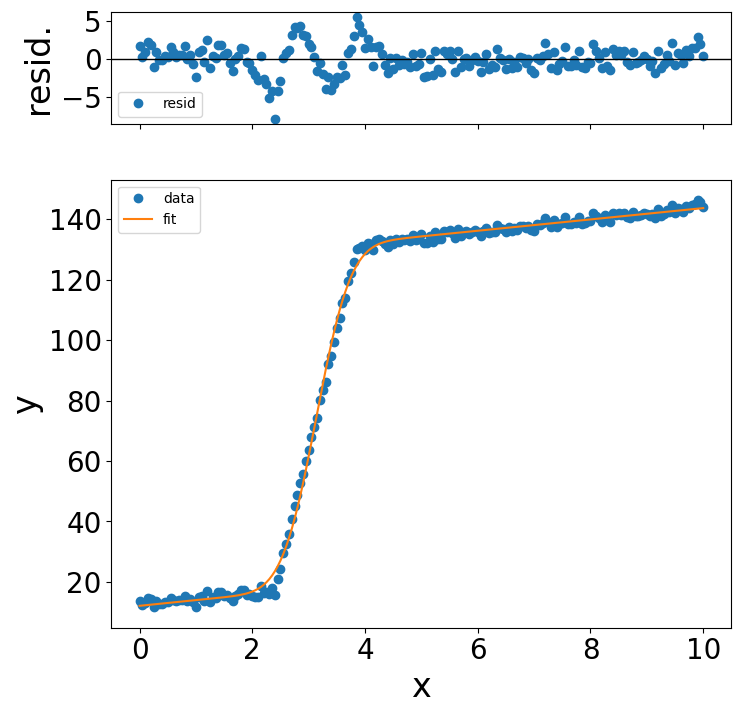

In [6]:
parstr = 'alpha'
lg.add_par(parstr)

pardict = {'alpha': {'value':0}}
lg.add_par(pardict)
pardict = {'alpha': {'value':0}}
lg.update_par(pardict)

params = lmfit.Parameters()
params.add("c0_amplitude_0", vary=True, min=-np.inf, max=10)
lg.add_par(params)
lg.update_par(params)

pardict = {'c0_amplitude_0': {'value':90, 'min':0}, 'c1_intercept_0': {'value':0, 'min':0}}
lg.update_par(pardict)

parexpr = {'c1_slope_0':'alpha + c0_center_0'}
lg.set_expr(parexpr, overwrite_expr=True)

lg.constrain('c1_intercept_0', expr='0.1*c0_amplitude_0', overwrite_expr=True)

lg.tie('c0_amplitude_0', 'c0_center_1', 'c1_intercept_0', overwrite_expr=True)

parvalue = {'c0_amplitude_0':5}
lg.set_value(parvalue)


lg.reset_params()
lg.fit(verbose=True)
# lg.result.params


lg.init_params


# self.r2_global = self.r2_dict["weighted"]

# lg.eval_components()
# lg.eval_components().keys()

# lg.rsquared
# lg.report()

lg.plot(plot_residual=True, xlabel='x', ylabel='y')